# Predict Unemployment Rate with Google Search Data and Intuition: A Simple Bayesian Regression Approach

COVID-19 has severely impacted the US economy.  Unemployment benefit claims surged suddenly in a short time.  The market is speculating about the unemployment rate when the Job Friday for March comes on April 3.  This notebook uses a well-documented appraoch to provide a quick and dirty estimate of the unemployment rate before a more accurate number is released.

The model uses a simple Bayesian regression technique that associates Google search freqeuncy for "Unemployment Benefits" with the unemployment rate.  With a prior heavily skewed towards the most recently reported number -- which provides the model an inertia, the model projects that the unemployment rate will lie between 8.2% to 10.6% with 80% chances.  This means that the unemployment rate can possibly increase from a 10-year low all the way to the peak level during the Financial Crisis.  An alternative specification that uses Gamma likelihood suggests a similar results, implying a 7% to 11.7% range.

## Install Prerequisites

In [1]:
! pip install pytrends
! pip install pystan
! pip install arviz

## Download Google Trend Data

In [0]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["Unemployment Benefits"]
pytrends.build_payload(kw_list, cat=0, timeframe='2004-01-01 2020-03-26', geo='', gprop='')
search = pytrends.interest_over_time().rename(columns = {'Unemployment Benefits': 'search'})

## Download Unemployment Rate Data from FRED 

In [0]:
import pandas_datareader as pdr
unrate = pdr.get_data_fred('UNRATE', start = "2004-01-01")

In [0]:
data = search.join(unrate)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Monthly Unemployment Rate')

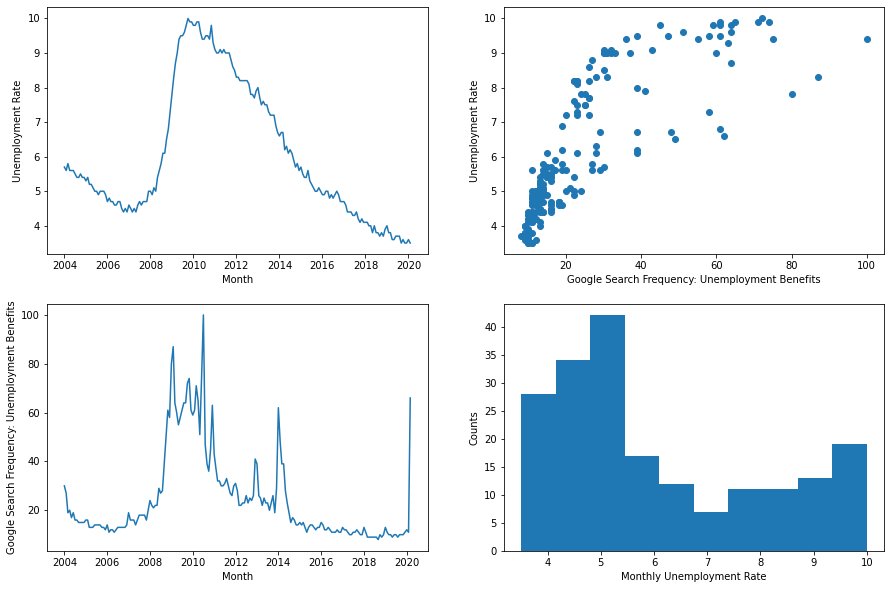

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.plot(data['UNRATE'])
ax3.plot(data['search'])
ax2.scatter(x = data['search'], y = data['UNRATE'])
ax4.hist(data['UNRATE'])

ax1.set_ylabel('Unemployment Rate')
ax1.set_xlabel('Month')

ax3.set_ylabel('Google Search Frequency: Unemployment Benefits')
ax3.set_xlabel('Month')

ax2.set_xlabel('Google Search Frequency: Unemployment Benefits')
ax2.set_ylabel('Unemployment Rate')

ax4.set_ylabel('Counts')
ax4.set_xlabel('Monthly Unemployment Rate')

## Prepare Data for Stan

In [0]:
import numpy as np
train_data = data[:-1]
pred_data = data[-1:]

x_raw = train_data['search'].values
x_bar = np.mean(x_raw)
x_sd = np.sqrt(np.var(x_raw))

x = (x_raw - x_bar)/x_sd
y = train_data['UNRATE'].values

x_pred = (pred_data['search'].values - x_bar)/x_sd

stan_data = dict(
    N = len(x),
    x = x,
    x2 = x**2,
    y = y,
    N_pred = len(x_pred),
    x_pred = x_pred,
    x2_pred = x_pred ** 2 
)

## Model Specification 1: Gaussian Regression

Priors:

$\alpha \sim N(3.5, 1)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\sigma \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim N(\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2, \sigma)$

In [0]:
gauss_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> sigma;
}
model {
  alpha ~ normal(3.5, 1);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  sigma ~ gamma(2, 0.5);
  y ~ normal(alpha + beta1 * x + beta2 * x2, sigma);
}
generated quantities {
  vector[N_pred] y_pred;
  for (i in 1:N_pred){
    y_pred[i] = normal_rng(alpha + beta1 * x_pred[i] + beta2 * x2_pred[i], sigma);
  }
}
"""

In [8]:
import pystan

iter = 5000
model_gauss = pystan.StanModel(model_code=gauss_model_code)
trace_gauss = model_gauss.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e363dadce3bbd339f0dc3b7a8136a62a NOW.


In [9]:
print(trace_gauss.stansummary())

Inference for Stan model: anon_model_e363dadce3bbd339f0dc3b7a8136a62a.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        6.6  9.5e-4   0.09   6.43   6.54    6.6   6.66   6.76   8048    1.0
beta1       2.55  1.4e-3   0.12   2.32   2.47   2.55   2.63   2.77   7041    1.0
beta2      -0.57  6.8e-4   0.06  -0.68  -0.61  -0.57  -0.53  -0.46   6552    1.0
sigma       0.92  4.2e-4   0.05   0.84   0.89   0.92   0.96   1.02  12828    1.0
y_pred[1]   9.44  7.0e-3   0.94   7.61   8.81   9.44  10.07  11.28  17859    1.0
lp__      -86.68    0.02   1.41 -90.27 -87.37 -86.38 -85.65 -84.92   7330    1.0

Samples were drawn using NUTS at Sat Mar 28 21:46:35 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbfe5dccc0>,
      dtype=object)

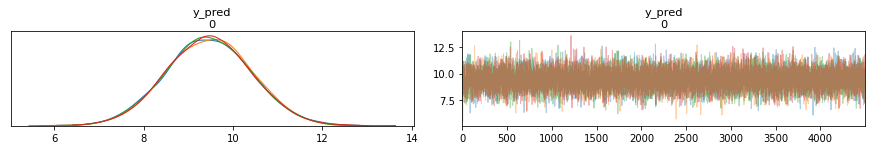

In [10]:
import arviz
arviz.plot_trace(trace_gauss, var_names = 'y_pred')

## Find 80% High Density Interval for Predicted Unemployment Rate 

In [11]:
p = 0.80

mcmc = trace_gauss.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(8.228771636148382, 10.629123659922284)


## Model Specification 2: Gamma Regression
Priors:

$\alpha \sim N(0, 10)$;

$\beta_1 \sim logN(0, 1)$;

$\beta_2 \sim N(0, 10)$;

$\theta \sim Gamma(2, 0.5)$;

Likelihood:

$y_i \sim Gamma\left(\frac{\alpha + \beta_1 \cdot x_i + \beta_2 \cdot x_i^2}{\theta}, \theta\right)$

In [0]:
gamma_model_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector<lower = 0>[N] x2;
  vector[N] y;
  int<lower=0> N_pred;
  vector[N_pred] x_pred;
  vector<lower = 0>[N_pred] x2_pred;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2; 
  real<lower=0> theta;
}
model {
  alpha ~ normal(0, 10);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 10);
  theta ~ gamma(2, 0.5);
  y ~ gamma((alpha + beta1 * x + beta2 * x2)/theta, theta);
}
generated quantities {
  vector[N_pred] y_pred;
  for (i in 1:N_pred){
    y_pred[i] = gamma_rng((alpha + beta1 * x_pred[i] + beta2 * x2_pred[i])/theta, theta);
  }
}
"""

In [13]:
iter = 5000
model_gamma = pystan.StanModel(model_code=gamma_model_code)
trace_gamma = model_gamma.sampling(data=stan_data, chains = 4, iter = iter, warmup = int(np.floor(iter/10)), thin = 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b17e442dd21e5441d247766da3f8c876 NOW.


In [14]:
print(trace_gamma.stansummary())

Inference for Stan model: anon_model_b17e442dd21e5441d247766da3f8c876.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      54.18    0.11   6.41  42.04  49.79  54.09  58.44  66.85   3571    1.0
beta1      19.99    0.05   2.77   14.8  18.08  19.92  21.81   25.7   3593    1.0
beta2      -4.21    0.01   0.88  -5.99   -4.8  -4.18  -3.59  -2.57   4310    1.0
theta       2.86  2.8e-3   0.17   2.51   2.74   2.86   2.97   3.19   3741    1.0
y_pred[1]   9.52    0.01   1.86    6.2   8.21   9.41  10.69  13.47  18254    1.0
lp__      -300.6    0.02   1.43 -304.2 -301.3 -300.3 -299.6 -298.9   5419    1.0

Samples were drawn using NUTS at Sat Mar 28 21:48:03 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbfd500518>,
      dtype=object)

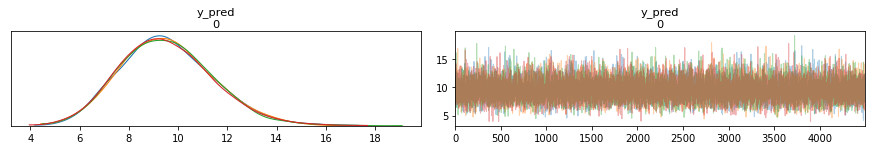

In [15]:
arviz.plot_trace(trace_gamma, var_names = 'y_pred')

In [16]:
p = 0.80

mcmc = trace_gamma.extract()
y_samp = mcmc['y_pred']
# rank order the draws
y_samp.reshape(1, -1)[0].sort()

# calculate the length of the CIs
ciIx = int(np.ceil(p * len(y_samp)))
nCIs = len(y_samp) - ciIx

# loop over all the CIs
ciWd = np.zeros(nCIs)
for i in range(nCIs):
  ciWd[i] = y_samp[i + ciIx] - y_samp[i]

# find the one with the shortest distance
hdiIx = np.argmin(ciWd)
print((y_samp[hdiIx][0], y_samp[hdiIx + ciIx][0]))

(7.054508348267044, 11.742703415330858)
